# 1. Load the processed data

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# 1. Load data from Step 4
df = pd.read_csv('/content/drive/MyDrive/Fake_Job_Posting_Detection/data/processed_data.csv')
df.head()

,telecommuting,has_company_logo,has_questions,word_count,unique_word_count,flesch_score,dale_chall_score,lexical_diversity,has_company_info,has_benefits,salary_explicit,log_company_credibility_score,location_encoded,required_experience_cleaned_encoded,employment_type_cleaned_encoded,industry_cleaned_encoded,function_cleaned_encoded,fraudulent
0,0,1,0,161.0,136.0,-157.307950,15.116055,0.844720,1,0,0,3.737670,2536,5,0,83,23,0
1,0,1,0,318.0,216.0,-304.555755,11.790945,0.679245,1,1,0,3.218876,1074,0,2,75,8,0
2,0,1,0,131.0,99.0,-152.160534,11.094967,0.755725,1,0,0,5.141664,1868,7,3,83,24,0
3,0,1,0,349.0,254.0,-380.595415,13.556080,0.727794,1,1,0,3.871201,1704,6,2,22,32,0
4,0,1,1,195.0,158.0,-226.668462,16.282850,0.810256,1,1,0,4.110874,1742,6,2,50,17,0


In [35]:
df.shape

(17880, 18)

# 2.Preparation & Imbalance Handling (SMOTE)
 we split our data and apply SMOTE only to the training set to avoid data leakage.

In [36]:
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']

# 2. Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Scaling (Crucial for SVM and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"Resampled Training Set Shape: {X_train_res.shape}")

Resampled Training Set Shape: (27222, 17)


# 3.Traditional ML Models
We created a helper function to evaluate each model consistently.

In [37]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, name):
    preds = model.predict(X_test)
    print(f"--- {name} Performance ---")
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### 3.1 Train Traditional Models

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      3403
           1       0.17      0.79      0.28       173

    accuracy                           0.81      3576
   macro avg       0.58      0.80      0.59      3576
weighted avg       0.95      0.81      0.86      3576



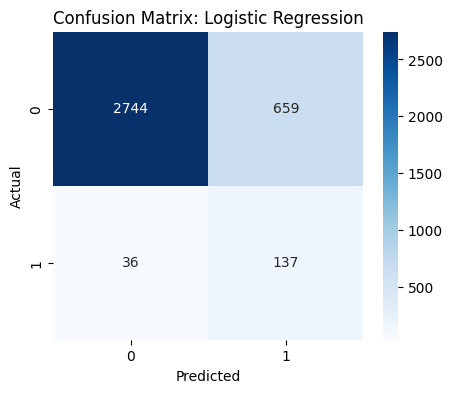

--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.77      0.74      0.76       173

    accuracy                           0.98      3576
   macro avg       0.88      0.86      0.87      3576
weighted avg       0.98      0.98      0.98      3576



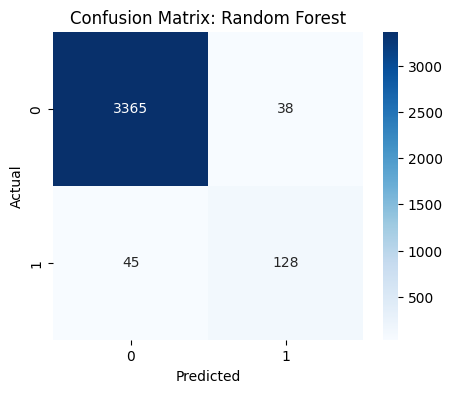

--- SVM Performance ---
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3403
           1       0.34      0.78      0.47       173

    accuracy                           0.92      3576
   macro avg       0.66      0.85      0.71      3576
weighted avg       0.96      0.92      0.93      3576



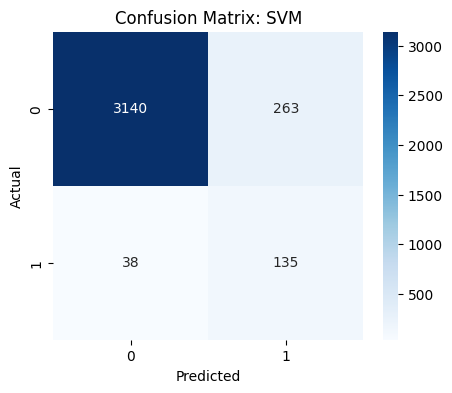

--- XGBoost Performance ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3403
           1       0.71      0.75      0.73       173

    accuracy                           0.97      3576
   macro avg       0.85      0.87      0.86      3576
weighted avg       0.97      0.97      0.97      3576



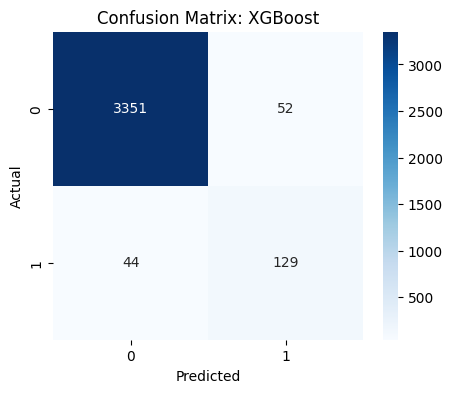

In [38]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
evaluate_model(lr, X_test_scaled, y_test, "Logistic Regression")

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
evaluate_model(rf, X_test_scaled, y_test, "Random Forest")

# 3. SVM (Support Vector Machine)
svm = SVC(probability=True)
svm.fit(X_train_res, y_train_res)
evaluate_model(svm, X_test_scaled, y_test, "SVM")

# 4. XGBoost
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)
evaluate_model(xgb, X_test_scaled, y_test, "XGBoost")

# 4. Hyperparameter Tuning

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1}
--- Tuned XGBoost Performance ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.77      0.74      0.76       173

    accuracy                           0.98      3576
   macro avg       0.88      0.86      0.87      3576
weighted avg       0.98      0.98      0.98      3576



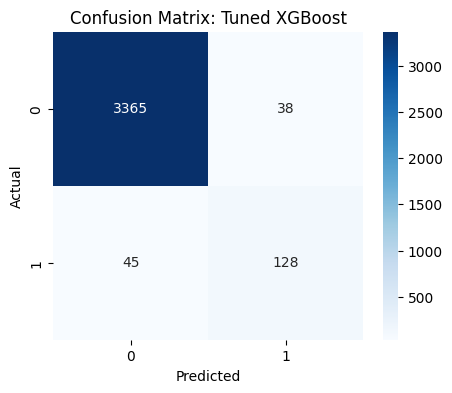

In [39]:
#  Hyperparameter Tuning: XGBoost
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

random_search = RandomizedSearchCV(XGBClassifier(), param_distributions=param_grid,
                                   n_iter=10, scoring='f1', cv=3, verbose=1)
random_search.fit(X_train_res, y_train_res)

print(f"Best Parameters: {random_search.best_params_}")
best_xgb = random_search.best_estimator_
evaluate_model(best_xgb, X_test_scaled, y_test, "Tuned XGBoost")

# 5. Pushing to github

In [40]:
!ls -R


.:
data  models  notebooks  README.md  src

./data:
processed_data.csv  raw

./data/raw:
fake_job_postings.csv

./models:

./notebooks:
01_exploratry_data_analysis.ipynb  03_Model_Training_Evaluation.ipynb
02_preprocessing.ipynb

./src:
